In [1]:
# Cell 1: Import required libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Cell 2: Download data and set key variables
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [3]:
# Cell 3: Create image generators
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

test_data_gen = test_image_generator.flow_from_directory(
    batch_size=1,
    directory=PATH,
    classes=['test'],
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    shuffle=False
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


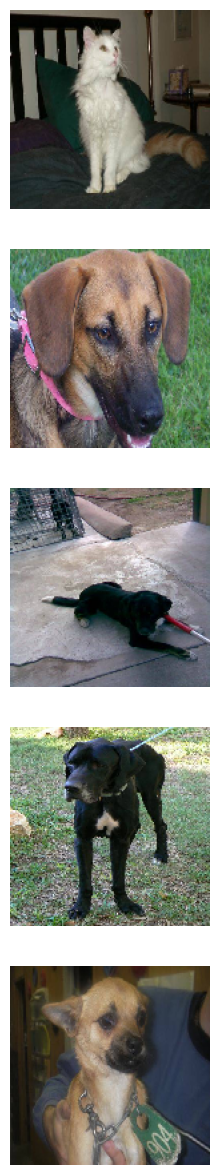

In [4]:
# Cell 4: Plot images function
def plotImages(images_arr, probabilities=False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5, len(images_arr) * 3))
    if probabilities is False:
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)
            ax.axis('off')
    else:
        for img, prob, ax in zip(images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis('off')
            if prob > 0.5:
                ax.set_title("%.2f%% dog" % (prob * 100))
            else:
                ax.set_title("%.2f%% cat" % ((1 - prob) * 100))
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [ ]:
# Cell 5: Recreate train_image_generator with data augmentation
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2
)

Found 2000 images belonging to 2 classes.


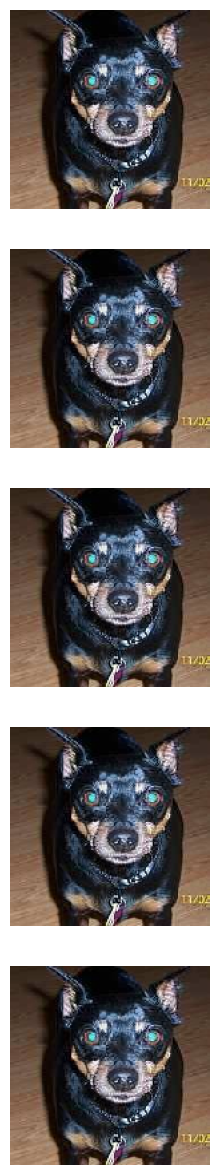

In [5]:
# Cell 6: Recreate train_data_gen and plot augmented images
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [6]:
# Cell 7: Create the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\JamJayDatuin\Documents\Machine Learning Projects\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Cell 8: Train the model
history = model.fit(
    x=train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

c:\Users\JamJayDatuin\Documents\Machine Learning Projects\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 190s 12s/step - accuracy: 0.5096 - loss: 0.6956 - val_accuracy: 0.5871 - val_loss: 0.6776
Epoch 2/15
 1/15 ━━━━━━━━━━━━━━━━━━━━ 2:04 9s/step - accuracy: 0.5703 - loss: 0.6880

c:\Users\JamJayDatuin\Documents\Machine Learning Projects\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.5703 - loss: 0.6880 - val_accuracy: 0.6138 - val_loss: 0.6773
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 154s 10s/step - accuracy: 0.5876 - loss: 0.6679 - val_accuracy: 0.6295 - val_loss: 0.6395
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5938 - loss: 0.6542 - val_accuracy: 0.6205 - val_loss: 0.6436
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 152s 10s/step - accuracy: 0.6277 - loss: 0.6429 - val_accuracy: 0.6663 - val_loss: 0.6344
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.7109 - loss: 0.6184 - val_accuracy: 0.6775 - val_loss: 0.6289
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 170s 11s/step - accuracy: 0.6485 - loss: 0.6346 - val_accuracy: 0.6562 - val_loss: 0.6230
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.6641 - loss: 0.6329 - val_accuracy: 0.6551 - val_loss: 0.6261
Epoch 9/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 150s 10s/step - accuracy: 0.6976 - loss: 0.5715 - val_accuracy: 0.6920 - val_loss: 0.

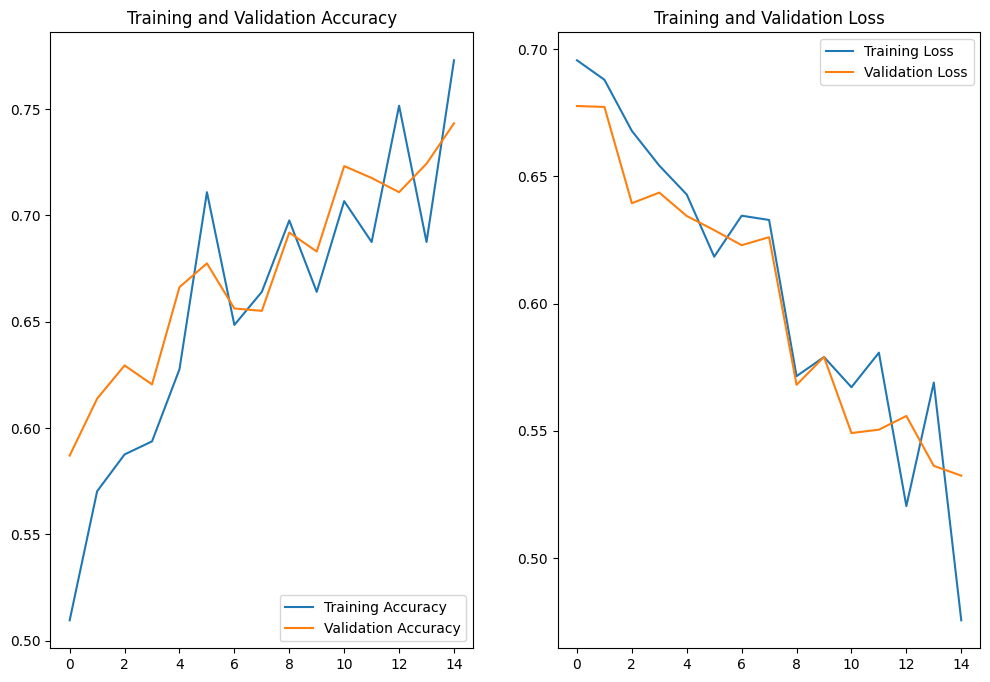

In [8]:
# Cell 9: Visualize accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


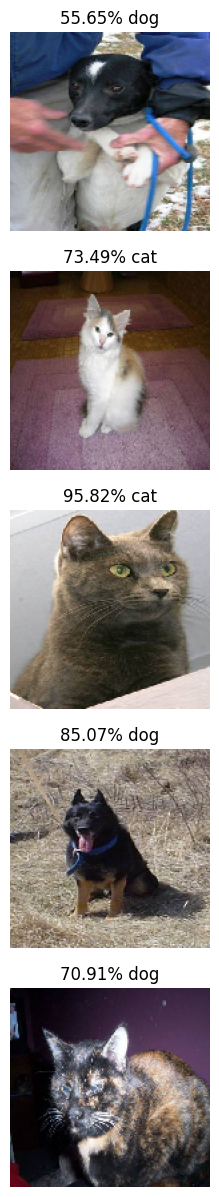

In [17]:
# Cell 10: Make predictions on test data
probabilities = model.predict(test_data_gen)
probabilities = probabilities.flatten()

# Reset and collect test images (since batch_size=1, we need to collect multiple batches)
test_data_gen.reset()
test_images = []
for i in range(5):
    img = next(test_data_gen)
    test_images.append(img[0])

# Plot first 5 test images with their predictions
plotImages(test_images, probabilities[:5])

In [18]:
# Cell 11: Check if passed
answers = [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]

correct = 0
for prob, answer in zip(probabilities, answers):
    if round(prob) == answer:
        correct += 1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
    print("You passed the challenge!")
else:
    print("You haven't passed yet. Keep trying!")

Your model correctly identified 68.0% of the images of cats and dogs.
You passed the challenge!
